# Blockdiag diagrams

Generate diagrams defined by http://blockdiag.com/en/

The following cell magic installer needs installing properly:

In [11]:
#via https://gist.github.com/sherdim/f0293bc7b022b852185b


# -*- coding: utf-8 -*-
from __future__ import print_function
from IPython.core.magic import (Magics, magics_class, line_magic,
                                cell_magic, line_cell_magic)
                                
# -*- coding: utf-8 -*-
"""magics for using blockdiag.com modules with IPython Notebook

The module provides magics:  %%actdiag, %%blockdiag, %%nwdiag, %%seqdiag

Sample usage (in IPython cell):

    %%blockdiag
    {
       A -> B -> C;
            B -> D;
    }

Some browsers do not properly render SVG, therefore PNG image is used by default.

Use magics %setdiagsvg and %setdiagpng to set SVG or PNG mode

PNG rendered on windows with default libraries does not support antialiasing,
resulting in a poor image quality

If inkscape is installed on the machine and can be found in system path,
the diagram is created as SVG and then rendered to PNG using inkscape.

Inkscape for windows can be downloaded from (http://inkscape.org/)

"""
from __future__ import print_function

import imp
import io
import os
import sys
import pipes
import subprocess
import tempfile

try:
    import hashlib
except ImportError:
    import md5 as hashlib

from IPython.core.magic import Magics, magics_class, cell_magic, line_cell_magic
from IPython.core.displaypub import publish_display_data

_draw_mode = 'PNG'
_publish_mode = 'PNG'

_inkscape_available = None

@magics_class
class BlockdiagMagics(Magics):
    """Magics for blockdiag and others"""

    def _import_all(self, module):
        for k, v in module.__dict__.items():
            if not k.startswith('__'):
                self.shell.push({k:v})

    def run_command(self, args, silent_except=False):
        try:
            startupinfo = None
            if os.name == 'nt':
                # Avoid a console window in Microsoft Windows.
                startupinfo = subprocess.STARTUPINFO()
                startupinfo.dwFlags |= subprocess.STARTF_USESHOWWINDOW
            subprocess.call(args, stderr=subprocess.STDOUT,
                                  startupinfo=startupinfo)
            return True
        except subprocess.CalledProcessError as e:
            print(e.output, file=sys.stderr)
            print("ERROR: command `%s` failed\n%s" %
                      ' '.join(map(pipes.quote, e.cmd)),
                      file=sys.stderr)
        except OSError as e:
            if not silent_except:
            	print ('Exception %s' % str(e), file=sys.stderr)
        return False

    def inkscape_available(self):
        global _inkscape_available
        if _inkscape_available is None:
            _inkscape_available = self.run_command(['inkscape', '--export-png'], silent_except=True)
        return _inkscape_available

    def svg2png(self, filename):
        self.run_command(['inkscape', filename + '.svg',
                '--export-png=' + filename + '.png'])

    def diag(self, line, cell, command):
        """Create sequence diagram using supplied diag methods."""
        code = cell + u'\n'
        # if inkscape is available create SVG for either case
        if self.inkscape_available():
            global _draw_mode
            _draw_mode = 'SVG'

        try:
            tmpdir = tempfile.mkdtemp()
            fd, diag_name = tempfile.mkstemp(dir=tmpdir)
            f = os.fdopen(fd, "wb")
            f.write(code.encode('utf-8'))
            f.close()

            format = _draw_mode.lower()
            draw_name = diag_name + '.' + format

            args = ['-T', format, '-o', draw_name, diag_name]
            # if os.path.exists(fontpath):
            #    sys.argv += ['-f', fontpath]

            # do not use PIL library when rendering to SVG
            # this allows avoid problem with handling unicode in diagram
            #~ if _draw_mode == 'SVG':
                #~ args += ['--ignore-pil']

            command.main(args=args)
            
            if _draw_mode == 'SVG' and _publish_mode == 'PNG':
                # render SVG with inkscape
                self.svg2png(diag_name)

            file_name = diag_name + '.' + _publish_mode.lower()
            with io.open(file_name, 'rb') as f:
                data = f.read()
                f.close()

        finally:
            for file in os.listdir(tmpdir):
                os.unlink(tmpdir + "/" + file)
            os.rmdir(tmpdir)

        if _publish_mode == 'SVG':
            publish_display_data(
                #~ u'IPython.core.displaypub.publish_svg',
                {'image/svg+xml':data}
            )
        else:
            publish_display_data(
                #~ u'IPython.core.displaypub.publish_png',
                {'image/png':data}
            )

    @cell_magic
    def actdiag(self, line, cell):
        import actdiag.command
        self.diag(line, cell, actdiag.command)

    @cell_magic
    def blockdiag(self, line, cell):
        import blockdiag.command
        self.diag(line, cell, blockdiag.command)

    @cell_magic
    def nwdiag(self, line, cell):
        import nwdiag.command
        self.diag(line, cell, nwdiag.command)

    @cell_magic
    def seqdiag(self, line, cell):
        import seqdiag.command
        self.diag(line, cell, seqdiag.command)

    @cell_magic
    def packetdiag (self, line, cell):
        """Depends on nwdiag."""
        import packetdiag.command
        self.diag(line, cell, packetdiag.command)

    @cell_magic
    def rackdiag (self, line, cell):
        """Depends on nwdiag."""
        import rackdiag.command
        self.diag(line, cell, rackdiag.command)
        
    @line_cell_magic
    def setdiagsvg(self, line, cell=None):
        global _draw_mode, _publish_mode
        _draw_mode = _publish_mode = 'SVG'

    @line_cell_magic
    def setdiagpng(self, line, cell=None):
        global _draw_mode, _publish_mode
        _draw_mode = _publish_mode = 'PNG'


_loaded = False

def load_ipython_extension(ip):
    """Load the extension in IPython."""
    global _loaded
    if not _loaded:
        ip.register_magics(BlockdiagMagics)
        _loaded = True

In [12]:
ip = get_ipython()
ip.register_magics(BlockdiagMagics)

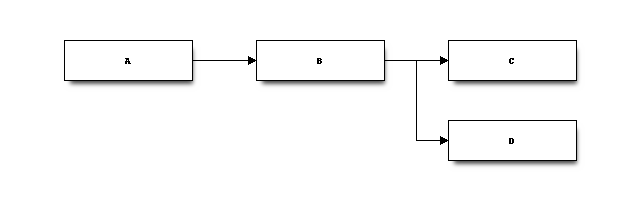

In [13]:
%%blockdiag
    {
       A -> B -> C;
            B -> D;
    }

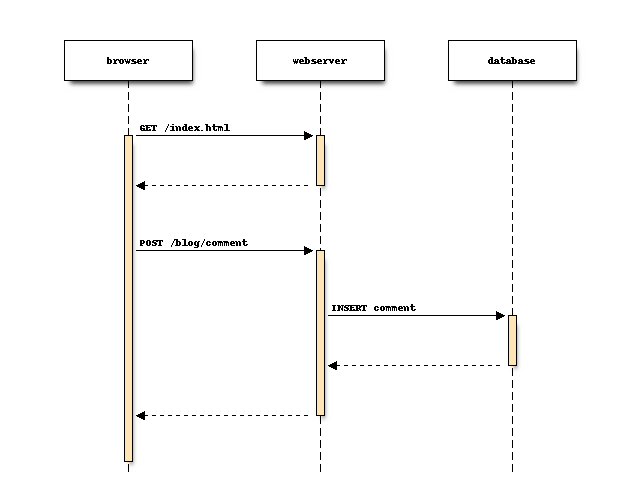

In [14]:
%%seqdiag 
{
  browser  -> webserver [label = "GET /index.html"];
  browser <-- webserver;
  browser  -> webserver [label = "POST /blog/comment"];
              webserver  -> database [label = "INSERT comment"];
              webserver <-- database;
  browser <-- webserver;
}

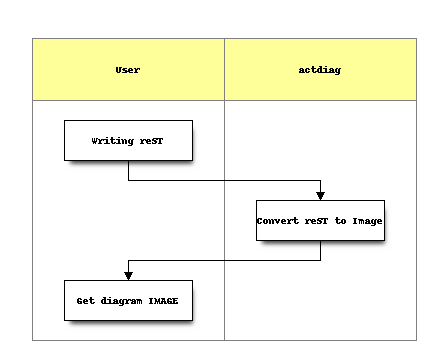

In [15]:
%%actdiag
{
  write -> convert -> image

  lane user {
     label = "User"
     write [label = "Writing reST"];
     image [label = "Get diagram IMAGE"];
  }
  lane actdiag {
     convert [label = "Convert reST to Image"];
  }
}


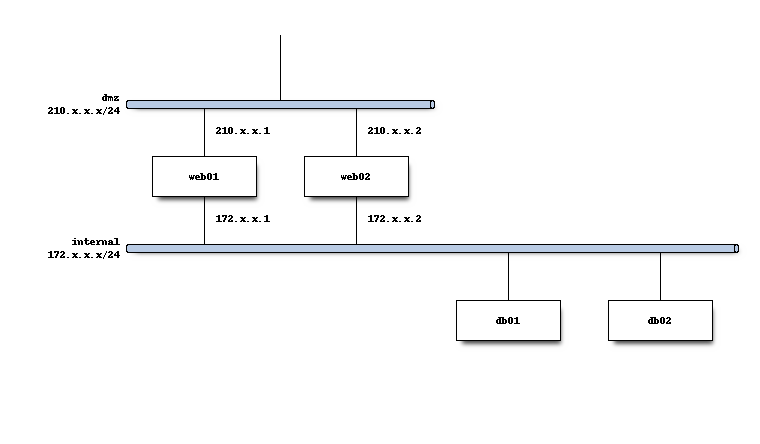

In [16]:
%%nwdiag
{
  network dmz {
      address = "210.x.x.x/24"

      web01 [address = "210.x.x.1"];
      web02 [address = "210.x.x.2"];
  }
  network internal {
      address = "172.x.x.x/24";

      web01 [address = "172.x.x.1"];
      web02 [address = "172.x.x.2"];
      db01;
      db02;
  }
}

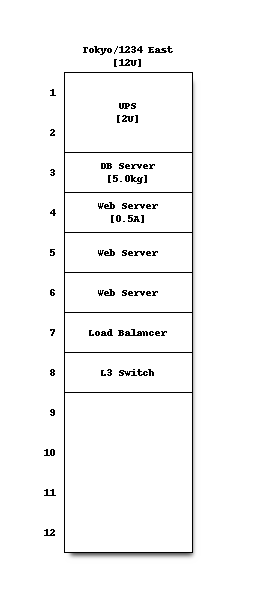

In [25]:
%%rackdiag
{
  // Change order of rack-number as ascending
  ascending;

  // define height of rack
  12U;

  // define description of rack
  description = "Tokyo/1234 East";

  // define rack units
  1: UPS [2U];   // define height of unit
  3: DB Server [5kg]  // define weight of unit
  4: Web Server [0.5A]  // define ampere of unit
  5: Web Server
  6: Web Server
  7: Load Balancer
  8: L3 Switch
}

In [26]:
%%packetdiag
{
  colwidth = 32
  node_height = 72

  0-15: Source Port
  16-31: Destination Port
  32-63: Sequence Number
  64-95: Acknowledgment Number
  96-99: Data Offset
  100-105: Reserved
  106: URG [rotate = 270]
  107: ACK [rotate = 270]
  108: PSH [rotate = 270]
  109: RST [rotate = 270]
  110: SYN [rotate = 270]
  111: FIN [rotate = 270]
  112-127: Window
  128-143: Checksum
  144-159: Urgent Pointer
  160-191: (Options and Padding)
  192-223: data [colheight = 3]
}

ERROR: images do not match


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpztgpv5ib/tmpr5zhbau3.png'